In [46]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [48]:
y = train_df['label'].values
X = train_df.drop('label', axis=1).values

## PyTorch implementation

### Prepare dataset

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
X_train = torch.tensor(X_train, dtype=torch.float32) / 255.0
X_val = torch.tensor(X_val, dtype=torch.float32) / 255.0
X_test = torch.tensor(test_df.values, dtype=torch.float32) / 255.0

In [51]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

In [52]:
# Needed for PyTorch, would've been easier to use PyTorch's own MNIST dataset in other circumstances
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [53]:
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### Prepare model

In [69]:
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[512, 256, 128], output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

### Train model

Plot results to identify overfitting and tune hyperparameters.

In [150]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [151]:
num_epochs = 50

In [152]:
best_val_acc = 0.0
best_model_path = 'best_model.pth'

In [153]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}")

    train_losses.append(loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)  # Save the best model
        print(f"New best model saved at epoch {epoch+1} with validation accuracy: {val_acc:.4f}")

Epoch 1/50, Train Loss: 0.5228, Train Acc: 0.8542, Val Loss: 0.1678, Val Acc: 0.9487
New best model saved at epoch 1 with validation accuracy: 0.9487
Epoch 2/50, Train Loss: 0.2733, Train Acc: 0.9205, Val Loss: 0.1358, Val Acc: 0.9585
New best model saved at epoch 2 with validation accuracy: 0.9585
Epoch 3/50, Train Loss: 0.2172, Train Acc: 0.9369, Val Loss: 0.1146, Val Acc: 0.9649
New best model saved at epoch 3 with validation accuracy: 0.9649
Epoch 4/50, Train Loss: 0.1975, Train Acc: 0.9420, Val Loss: 0.1007, Val Acc: 0.9683
New best model saved at epoch 4 with validation accuracy: 0.9683
Epoch 5/50, Train Loss: 0.1727, Train Acc: 0.9475, Val Loss: 0.0991, Val Acc: 0.9690
New best model saved at epoch 5 with validation accuracy: 0.9690
Epoch 6/50, Train Loss: 0.1676, Train Acc: 0.9514, Val Loss: 0.0917, Val Acc: 0.9708
New best model saved at epoch 6 with validation accuracy: 0.9708
Epoch 7/50, Train Loss: 0.1518, Train Acc: 0.9554, Val Loss: 0.0900, Val Acc: 0.9719
New best model 

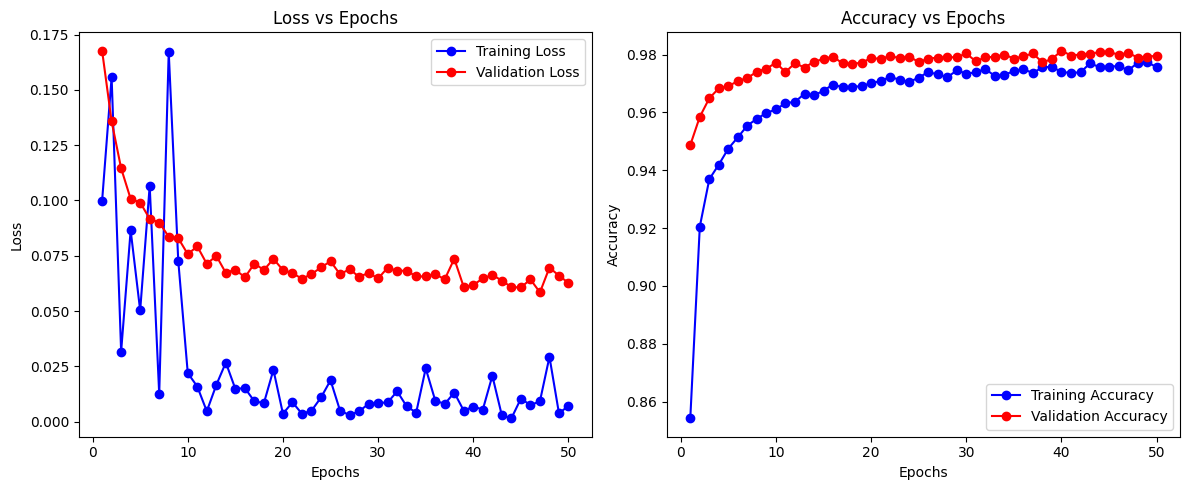

In [154]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluate model

In [155]:
best_model = MLP()
best_model.load_state_dict(torch.load(best_model_path))

/tmp/ipykernel_36/323086140.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [156]:
best_model.eval()
correct = 0
total = 0

In [157]:
with torch.no_grad():
    for images, labels in val_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 98.13%


### Grab submission

In [158]:
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [159]:
model.eval()

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [160]:
all_predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0] 
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.append(predictions.numpy())

In [161]:
all_predictions = np.concatenate(all_predictions)

predictions_list = all_predictions.tolist()

In [162]:
submission = pd.DataFrame(predictions_list)
submission.index.name='ImageId'
submission.index+=1
submission.columns=['Label']

In [163]:
submission.to_csv('submission.csv', index="ImageId")